## Соревнование на площадке kaggle

https://www.kaggle.com/c/recommendations-skill-factory-mlo-11/leaderboard

 - Необходимо создать модель, которая делает максимально релевантные рекомендации фильмов для пользователей онлайн-кинотеатра. 
 - Доступна история просмотров, а так же некоторая мета-информация о фильмах. 
 - Целевая метрика: NDCG@10

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from collections import Counter
import math

import pandas as pd
import numpy as np

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn 
seaborn.set()

from IPython.core.display import display, HTML
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix

from sklearn.feature_extraction.text import CountVectorizer

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test_user_id.list', 'submit.csv', 'movies.csv', 'tags.csv', 'train.csv']


### Загрузка обучающих данных

In [2]:
ratings = pd.read_csv('../input/train.csv') #обучающие данные
movies = pd.read_csv('../input/movies.csv') #файл с мета-информацией о фильмах
tags = pd.read_csv('../input/tags.csv') #файл с мета-информацией о соответствующих тегах

In [3]:
##подключение тэгов
#un_tags = pd.unique(tags.tag)
#for i in range(len(un_tags)):
#    tagsi = tags[tags.tag == un_tags[i]]
#    for j in range(tagsi.shape[0]):
#        c1 = np.where(ratings.userId - tagsi.userId.values[j] == 0)
#        c2 = np.where(ratings.movieId - tagsi.movieId.values[j] == 0)
#        a = np.intersect1d(c1, c2)
#        if a:
#            print(i,j)

In [4]:
print(ratings.shape)
ratings.tail()

(1038712, 4)


,userId,movieId,rating,timestamp
1038707,5014,2987,4.0,1225285809
1038708,114932,527,4.5,1225285812
1038709,114932,608,4.0,1225285818
1038710,5014,589,5.0,1225285818
1038711,5014,1097,4.0,1225285821


In [5]:
print(movies.shape)
movies.tail()

(27278, 3)


,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure|Fantasy|Horror


В данных для некоторых фильмов пропущены жанры:

In [6]:
movies.loc[movies['genres'] == '(no genres listed)']

,movieId,title,genres
16574,83773,Away with Words (San tiao ren) (1999),(no genres listed)
16589,83829,Scorpio Rising (1964),(no genres listed)
16764,84768,Glitterbug (1994),(no genres listed)
17080,86493,"Age of the Earth, The (A Idade da Terra) (1980)",(no genres listed)
17243,87061,Trails (Veredas) (1978),(no genres listed)
18246,91246,Milky Way (Tejút) (2007),(no genres listed)
18566,92435,"Dancing Hawk, The (Tanczacy jastrzab) (1978)",(no genres listed)
18606,92641,Warsaw Bridge (Pont de Varsòvia) (1990),(no genres listed)
18984,94431,"Ella Lola, a la Trilby (1898)",(no genres listed)
19015,94657,"Turkish Dance, Ella Lola (1898)",(no genres listed)


Кодируем жанры и уберем столбцы  "no", "genres" ,"listed"

In [7]:
vec = CountVectorizer()
xv = vec.fit_transform(movies.genres)    
movies_vec = pd.DataFrame(xv.toarray(),columns = vec.get_feature_names())
print(movies_vec.shape)
movies_vec.tail()

(27278, 24)


,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,film,genres,horror,imax,listed,musical,mystery,no,noir,romance,sci,thriller,war,western
27273,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27274,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27275,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27276,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
27277,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [8]:
movies_vec_drop = movies_vec.drop(columns=['no','genres', 'listed'])
print(movies_vec_drop.shape)
movies_vec_drop.tail()

(27278, 21)


,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,film,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
27273,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27274,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27275,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27276,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27277,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


Преобразованная выборка с мета-информацией о фильмах movies выглядит так:

In [9]:
movies_all = pd.concat([movies,movies_vec_drop],axis=1)
movies_all = movies_all.drop('genres',axis=1);
print(movies_all.shape)
movies_all.tail()

(27278, 23)


,movieId,title,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,film,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
27273,131254,Kein Bund für's Leben (2007),0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27274,131256,"Feuer, Eis & Dosenbier (2002)",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27275,131258,The Pirates (2014),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27276,131260,Rentun Ruusu (2001),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
27277,131262,Innocence (2014),0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


Добавим жанры к обучающей выборке ratings:

In [10]:
ratings_part2 = movies_all.set_index('movieId').loc[ratings.movieId].reset_index().drop(['movieId','title'],axis=1);
print(ratings_part2.shape)
ratings_part2

(1038712, 21)


,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,film,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
ratings_new = pd.concat([ratings,ratings_part2],axis=1)
print(ratings_new.shape)
ratings_new

(1038712, 25)


,userId,movieId,rating,timestamp,action,adventure,animation,children,comedy,crime,documentary,drama,fantasy,fi,film,horror,imax,musical,mystery,noir,romance,sci,thriller,war,western
0,79366,1407,4.0,874357760,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,79366,260,5.0,874357917,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
2,79366,36,4.0,874357965,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,79366,800,4.0,874357996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1
4,79366,32,4.0,874358033,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0
5,79366,1393,4.0,874358073,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
6,79366,745,4.0,874358116,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,79366,1,4.0,874358116,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,79366,647,4.0,874358187,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
9,79366,1041,4.0,874358488,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


Умножим жанры на рейтинги:

In [12]:
ratings_new2 = ratings_new.copy()
for i in range(len(ratings_part2.columns)):
    ratings_new2[ratings_part2.columns[i]] = ratings_new[ratings_part2.columns[i]].mul(ratings_new.rating-3)

Суммируем все жанры которые посмотрел пользователь:

In [13]:
userId_un = pd.unique(ratings_new.userId)
matrix_userId_un = np.zeros([len(userId_un),len(ratings_part2.columns)])
k=0
for i in userId_un:
   matrix_userId_un[k,:] = np.sum(ratings_new2[ratings_new.userId==i][ratings_part2.columns],axis=0)
   k+=1

Заполнение столбцов и строк сжатой матрицы:

In [14]:
rows=[];
cols=[];
vals=[];
for i in range(matrix_userId_un.shape[0]):
    for j in range(matrix_userId_un.shape[1]):
        if matrix_userId_un[i,j]>0:
            rows.append(i)
            cols.append(j+movies.shape[0])
            #cols.append(j)
            vals.append(matrix_userId_un[i,j])

In [15]:
ratings = ratings_new2.copy()

Тестовое множество - набор идентификаторов пользователей, для которых нужно сделать предсказания. Сохраним их в лист test_user_id. 

In [16]:
with open('../input/test_user_id.list', 'r') as file:
    test_user_id = file.read()
test_user_id = [int(user_id) for user_id in test_user_id.split(',')]

### Разделим данные на обучение и валидацию

In [17]:
sorted_timestamps = sorted(ratings['timestamp'])
total_actions = len(sorted_timestamps)
border_timestamp = sorted_timestamps[int(total_actions*0.75)]
train = ratings[ratings.timestamp <= border_timestamp]
validation = ratings[ratings.timestamp > border_timestamp]
train.shape, validation.shape

((779035, 25), (259677, 25))

In [18]:
#train = ratings[:int(ratings.shape[0] * 0.75)]
#validation = ratings[int(ratings.shape[0] * 0.75):]
#train.shape, validation.shape

Реализация целевой метрики
Задача - предсказать релевантность фильмов тому или иному пользователю. Релевантность - это функция, характерезующая насколько объект(в нашем случае - фильм) подходит пользователю. Чем выше значение функции релевантности, тем больше фильм подходит пользователю.

При этом, так как мы строим рекомендательную систему, наша задача - найти самые релевантные фильмы для пользователя. Поэтому нам не важно абсолютное значение релевантности, а важен порядок, в соответствии с которым мы выстроили фильмы согласно функции релевантности.

Такая (в котором нам важно упорядочить элементы) задача называется задачей ранжировани. Кроме рекомендательной системы, задачу ранжирования например решает поисковая система: ее задача упорядочить web-страницы в порядке релевантности запросу пользователя.

Для того чтобы измерить качество ранжирования нам понадобится специальная метрика: NDCG (Normalized Discounted Cummulative Gain). Еее идея заключается в том, что она сравнивает порядок в котором мы упорядочили фильмы с идеальным порядком (при котором сначала стоят самые релевантные фильмы, а в конце самые нерелевантные). Если элемент стоит дальше того места где ему положено стоять - NDCG уменьшает свое значение. При этом она учитывает номер номер на котором произошло нарушение порядка: понятно что поменять местами 1-й и 10й фильмы намного хуже чем 101-й и 110-й. На первую рекомендацию пользователь посмотрит гарантировано (и там окажется элемент, который должен был бы быить 10м), а да 101-го с большой вероятностью просто не дойдет.

Важность позиции в NDCG убывает в соответствии с обратным логарифмическим законом.

При использовании метрики NDCG@K, важность позиций с номером большем чем K полагается равной нулю.

Более подробно про метрику NDCG (с формулами!) можете почитать по ссылке: https://habr.com/company/econtenta/blog/303458/

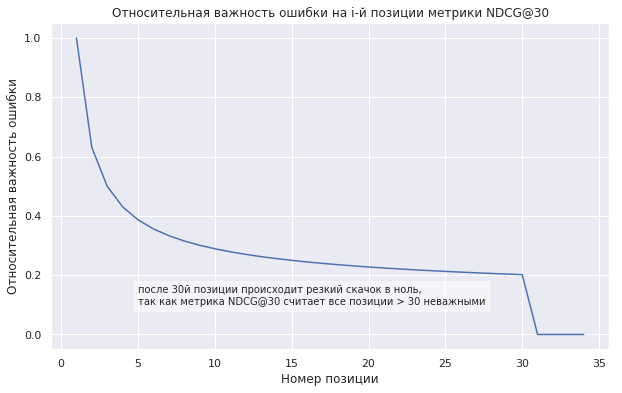

In [19]:
K = 30
max_n = 35

x = [i for i in range(1, max_n)]
y = [(i <= K) * 1/math.log2(i + 1) for i in range(1, max_n)]

plt.figure(figsize=(10, 6))
plt.title("Относительная важность ошибки на i-й позиции метрики NDCG@{}".format(K))
plt.xlabel("Номер позиции")
plt.ylabel("Относительная важность ошибки")
plt.text(5, 0.1, """после {}й позиции происходит резкий скачок в ноль,
так как метрика NDCG@{} считает все позиции > {} неважными""".format(K, K, K), bbox=dict(facecolor='white', alpha=0.5))

plt.plot(x, y);
plt.show();

In [20]:
def dcg_at_k(r, k, method=0):
    """
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Discounted cumulative gain
    """
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.



def ndcg_at_k(r, k, method=0):
    """
    Args:
        r: Relevance scores (list or numpy) in rank order
            (first element is the first item)
        k: Number of results to consider
        method: If 0 then weights are [1.0, 1.0, 0.6309, 0.5, 0.4307, ...]
                If 1 then weights are [1.0, 0.6309, 0.5, 0.4307, ...]
    Returns:
        Normalized discounted cumulative gain
    """
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

### Реализация топ-рекоммендера

In [21]:
class TopRecommender(object):
    def fit(self, train_data):
        counts = Counter(train_data['movieId'])
        self.predictions = counts.most_common()
        
    def predict(self, user_id, n_recommendations=10):
        return [movie_id for movie_id, frequency in self.predictions[:n_recommendations]]

### Реализация SVDRecommender

In [22]:
class SVDRecommender(object):
    
    def create_viewed_matrix(self,data):
        self.users = defaultdict(lambda: len(self.users))
        self.movies = defaultdict(lambda: len(self.movies))
        rows = data.userId.apply(lambda userId: self.users[userId])
        cols = data.movieId.apply(lambda movieId: self.movies[movieId])
        vals = [1.0]* len(cols)
        print(len(rows))
        self.viewed_matrix = csr_matrix((vals, (rows, cols)))
        
    def fit(self, data, n_components = 30):    
        
        self.top_recommender = TopRecommender()
        self.top_recommender.fit(data)
        
        #Имитация неявной обрктной связи
        data_implicit = data
        
        #Создаем словарии соотвествия
        #UserID -> Номер строки в матрице
        #MovieId -> Номер колонки в матрице
        self.users = defaultdict(lambda: len(self.users))
        self.movies = defaultdict(lambda: len(self.movies))
       
        #Создаем матрицу взаимодействий пользователь -> фильм
        rows = data.userId.apply(lambda userId: self.users[userId])
        cols = data.movieId.apply(lambda movieId: self.movies[movieId])
        #vals = [1.0]* len(cols)
        vals = data.rating-3
        self.interactions_matrix = csr_matrix((vals, (rows, cols)))
        
        #Обучаем модель SVD
        self.model = TruncatedSVD(n_components = n_components, algorithm='arpack') #algorithm='randomized'
        self.model.fit(self.interactions_matrix)
        
        #Обратный словарь колонка -> ID фильма. Понадобится для предсказаний 
        self.movies_reverse = {}
        for movie_id in self.movies:
            movie_idx = self.movies[movie_id]
            self.movies_reverse[movie_idx] = movie_id
            
    def fit_huge(self, data, rows_add, cols_add, vals_add, n_components = 30,lys=5):    
        
        self.top_recommender = TopRecommender()
        self.top_recommender.fit(data)
        
        #Имитация неявной обрктной связи
        data_implicit = data
        
        #Создаем словарии соотвествия
        #UserID -> Номер строки в матрице
        #MovieId -> Номер колонки в матрице
        self.users = defaultdict(lambda: len(self.users))
        self.movies = defaultdict(lambda: len(self.movies))
       
        #Создаем матрицу взаимодействий пользователь -> фильм
        rows = data.userId.apply(lambda userId: self.users[userId])
        cols = data.movieId.apply(lambda movieId: self.movies[movieId])
        #vals = [1.0]* len(cols)
        #vals = data.rating-3
        
        def wtime(times,maxw,maxtime,stdt):
            return maxw*np.exp(-(times-maxtime)**2/(2*stdt*stdt))
        maxtime=max(data.timestamp)
        stdt=lys*(365*3600*24)#YEARS
        vals = (data.rating-3)* wtime(data.timestamp,1,maxtime,stdt)
        
        rows = np.array(rows)
        rows_add = np.array(rows_add)
        cols = np.array(cols)
        cols_add = np.array(cols_add)
        vals = np.array(vals)
        vals_add = np.array(vals_add)
        rows_new = np.concatenate([rows,rows_add])
        cols_new = np.concatenate([cols,cols_add])
        vals_new = np.concatenate([vals,vals_add])
        
        self.interactions_matrix = csr_matrix((vals_new, (rows_new, cols_new)))
        
        #Обучаем модель SVD
        self.model = TruncatedSVD(n_components = n_components, algorithm='arpack') #algorithm='randomized'
        self.model.fit(self.interactions_matrix)
        
        #Обратный словарь колонка -> ID фильма. Понадобится для предсказаний 
        self.movies_reverse = {}
        for movie_id in self.movies:
            movie_idx = self.movies[movie_id]
            self.movies_reverse[movie_idx] = movie_id           
        
    def predict(self, user_id, n_recommendations=10):  
        if user_id not in self.users:
            return self.top_recommender.predict(user_id,n_recommendations)
        
        #Получить представление пользователя в сниженной размерности     
        user_interactions = self.interactions_matrix.getrow(self.users[user_id])    
        user_low_dimensions = self.model.transform(user_interactions)  
        return self.predict_low_dimension(user_low_dimensions, user_interactions, n_recommendations)
    
    def predict_low_dimension(self, user_low_dimensions, user_interactions, max_n=10):
        #Получить приближенное представление пользователя
        user_predictions = self.model.inverse_transform(user_low_dimensions)[0]
        recommendations = []
        
        #Пробегаем по колонкам в порядке убывания предсказанного значения
        for movie_idx in reversed(np.argsort(user_predictions)):
            #Добавляем фильм к рекомендациям только если пользователь его еще не смотрел
            if user_interactions[0, movie_idx] == 0.0:
                movie = self.movies_reverse[movie_idx]
                score = user_predictions[movie_idx]
                #recommendations.append((movie, score))
                recommendations.append(movie)
            if (len(recommendations) >= max_n):
                return recommendations

In [23]:
#recommender_train = SVDRecommender()
#recommender_train.create_viewed_matrix(train)
#viewed_matrix_dense = recommender_train.viewed_matrix.todense()
#usrs = recommender_train.users
#movs = recommender_train.movies
#print(len(usrs))
#print(len(movs))

Построим модель и посмотрим на качество по метрике NDCG@10 на валидационном множестве

In [24]:
#recommender_train = TopRecommender()
recommender_train = SVDRecommender()
recommender_train.fit_huge(train, rows, cols, vals,n_components = 30,lys=0.1)

In [25]:
#from lightgbm import LGBMRanker
#lgbranker = LGBMRanker()
#csrmatrix = recommender_train.return_inter_matrix(train)
#lgbranker.fit(csrmatrix,train.userId)

In [26]:
verbose = True
num_to_print = 10
total_ndcg = 0

for user_id, group in validation.groupby('userId'):
    ground_truth_films = [int(data.movieId) for row, data in group.iterrows()]
    recommendations = recommender_train.predict(user_id, n_recommendations=10)
    relevance_scores = []
    for rec in recommendations:
        if rec in ground_truth_films:
            relevance_scores.append(len(ground_truth_films) - ground_truth_films.index(rec))
        else:
            relevance_scores.append(0)
    total_ndcg += ndcg_at_k(relevance_scores, k=10)
    
    if verbose and np.random.random() > 0.999:
        user_films_train = train[train.userId == user_id].movieId.values
        print('Идентификатор пользователя: ', user_id)
        print(
            'Фильмы в обучающей выборке для этого пользователя:',
            [movies[movies.movieId == movie_id].title.values[0] for movie_id in user_films_train[:num_to_print]],
            '\n'
        )
        print(
            'Просмотренные на самом деле фильмы: ', 
            [movies[movies.movieId == movie_id].title.values[0] for movie_id in ground_truth_films[:num_to_print]],
            '\n'
        )
        print(
            'Рекомендации топ-рекомендера: ', 
            [movies[movies.movieId == rec_id].title.values[0] for rec_id in recommendations],
            '\n'
        )
        print('Значение NDCG@10 = ', ndcg_at_k(relevance_scores, k=10), '\n\n')

Идентификатор пользователя:  24964
Фильмы в обучающей выборке для этого пользователя: ['Godfather: Part II, The (1974)', 'Breakfast Club, The (1985)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Forrest Gump (1994)', "It's a Mad, Mad, Mad, Mad World (1963)", 'Braveheart (1995)', 'Grand Canyon (1991)', 'Godfather, The (1972)', 'Misérables, Les (1995)', 'Shawshank Redemption, The (1994)'] 

Просмотренные на самом деле фильмы:  ['Tsotsi (2005)', 'Japanese Story (2003)', 'Departed, The (2006)', 'Darjeeling Limited, The (2007)', 'Bucket List, The (2007)', 'Juno (2007)', 'Cinderella Man (2005)', 'Blood Diamond (2006)', 'Inside Man (2006)', 'Shine (1996)'] 

Рекомендации топ-рекомендера:  ['Children of Men (2006)', 'Blood Diamond (2006)', 'Letters from Iwo Jima (2006)', "Pan's Labyrinth (Laberinto del fauno, El) (2006)", 'Notes on a Scandal (2006)', 'Lives of Others, The (Das leben der Anderen) (2006)', 'Queen, The (2006)', 'Little Children (2006)', 'Casino Royale (2006)', 'Knocked 

In [27]:
total_ndcg / validation.shape[0]

0.008688156930299082

### Обучим свд-рекоммендер на всем обучающем множестве


In [28]:
#recommender = TopRecommender()
recommender = SVDRecommender()
recommender.fit_huge(ratings, rows, cols, vals,n_components = 30,lys=0.1)

Попробуем сделать предсказание для первого пользователя в тесте

In [29]:
recommender.predict(user_id=test_user_id[0], n_recommendations=10)

[4993, 7153, 5952, 33794, 6874, 589, 296, 2329, 1198, 7438]

### Создание файла с решением

In [30]:
with open('submity.csv', 'w') as f:
    f.write('userId,movieId\n')
    for user_id in test_user_id:
        recommendations = recommender.predict(user_id=user_id, n_recommendations=10)
        for rec in recommendations:
            f.write(str(user_id) + ',' + str(int(rec)) + '\n')
    print('Отлично! Время загрузить файл submit.csv на kaggle!')

Отлично! Время загрузить файл submit.csv на kaggle!
